# Previsão de saúde mental 

In [6]:
# Importando bibliotecas necessárias
import pandas as pd
import sweetviz as sv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import shap
from pycaret.classification import *
import interpret_community
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

In [7]:
# leitura dos dados
df = pd.read_csv("bd.csv")
df.head()

,Mental_Health,Employment,Gender,Income,children,Physical_Activity,Race,body_mass_index,Education,Marital,...,Errands_Alone,Alcohol,Smoke,Heart_Disease,Stroke,Depression,Diabetes,COP,Skin_Cancer,Cancer
0,Good,no,female,35k - 50k,no children,no physical activity,White,Overweight,Graduated High School,Never married,...,no,yes,no,no,no,yes,No,no,no,no
1,Bad,yes,female,25k - 35k,no children,had physical activity,White,Obese,Graduated High School,Married,...,no,no,no,no,no,no,No,no,no,yes
2,Good,no,male,25k - 35k,no children,had physical activity,White,Overweight,Graduated High School,Married,...,no,no,no,no,no,no,No,no,yes,no
3,Good,no,male,150k - 200k,two children,had physical activity,White,Overweight,Graduated from College or Technical School,Married,...,no,yes,no,no,no,no,No,no,no,no
4,Good,no,male,100k - 150k,no children,had physical activity,White,Overweight,Graduated from College or Technical School,Married,...,no,no,no,no,no,no,No,yes,no,no


In [8]:
# Análise Exploratória dos Dados 

#eda = sv.analyze(df)
eda.show_html(open_browser=True)

                                             |                                             | [  0%]   00:00 ->…

KeyboardInterrupt: 

In [9]:
# Transformando algumas variáveis para facilitar a interpretação

# Filhos 

df['children_t'] = np.where(df['children'] == 'no children', 'zero children', 'more than one children') 

# Renda 

conditions = [
    (df['Income'] == 'Less than $10k') | (df['Income'] == '$10k - 15K') |
    (df['Income'] == '20k - 25k') | (df['Income'] == '25k - 35k') | 
    (df['Income'] == '35k - 50k'),
    (df['Income'] == '50k - 75k') | (df['Income'] == '75k - 100k'),
    (df['Income'] == '100k - 150k') | (df['Income'] == '150k - 200k') | (df['Income'] == '200k or more')
    
]

values = ['less than 50k','50k - 100k', '100k or more']

df['Income_t'] = np.select(conditions, values)

df.head()


# Vamos excluir as variáveis originais 

df = df.drop(columns=['children', 'Income'])
df.head()

,Mental_Health,Employment,Gender,Physical_Activity,Race,body_mass_index,Education,Marital,Deaf,Blind,...,Smoke,Heart_Disease,Stroke,Depression,Diabetes,COP,Skin_Cancer,Cancer,children_t,Income_t
0,Good,no,female,no physical activity,White,Overweight,Graduated High School,Never married,no,no,...,no,no,no,yes,No,no,no,no,zero children,less than 50k
1,Bad,yes,female,had physical activity,White,Obese,Graduated High School,Married,no,no,...,no,no,no,no,No,no,no,yes,zero children,less than 50k
2,Good,no,male,had physical activity,White,Overweight,Graduated High School,Married,no,no,...,no,no,no,no,No,no,yes,no,zero children,less than 50k
3,Good,no,male,had physical activity,White,Overweight,Graduated from College or Technical School,Married,no,no,...,no,no,no,no,No,no,no,no,more than one children,100k or more
4,Good,no,male,had physical activity,White,Overweight,Graduated from College or Technical School,Married,no,no,...,no,no,no,no,No,yes,no,no,zero children,100k or more


In [10]:
# Dummificando as variáveis 
df_t = pd.get_dummies(df, drop_first=True)
df_t.head()

,Mental_Health_Good,Employment_yes,Gender_male,Physical_Activity_no physical activity,Race_Asian,Race_Black,Race_Hispanic,Race_Other race,Race_White,body_mass_index_Obese,...,"Diabetes_No, pre-diabetes or borderline diabetes",Diabetes_Yes,"Diabetes_Yes, only during pregnancy",COP_yes,Skin_Cancer_yes,Cancer_yes,children_t_zero children,Income_t_100k or more,Income_t_50k - 100k,Income_t_less than 50k
0,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
1,0,1,0,0,0,0,0,0,1,1,...,0,0,0,0,0,1,1,0,0,1
2,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,1
3,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,1,0,0


In [11]:
# vamos separar duas bases, uma para treino e outra para teste
treino = df_t.sample(frac=.8, random_state=123)
treino.reset_index(inplace=True, drop=True)


teste = df_t.drop(treino.index)
teste.reset_index(inplace=True, drop=True)

print(treino.shape, teste.shape)

(131515, 41) (32879, 41)


# Modelo sem nenhum tipo de tunagem de hiperparâmetros

In [12]:
# Criando uma sessão ho pycaret

clf = setup(data=treino, target="Mental_Health_Good", session_id=123)


,Description,Value
0,Session id,123
1,Target,Mental_Health_Good
2,Target type,Binary
3,Original data shape,"(131515, 41)"
4,Transformed data shape,"(131515, 41)"
5,Transformed train set shape,"(92060, 41)"
6,Transformed test set shape,"(39455, 41)"
7,Numeric features,40
8,Preprocess,True
9,Imputation type,simple


In [13]:
# Avaliando o melhor modelo 

best_model = compare_models(fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7031,0.7337,0.8792,0.7003,0.7796,0.3420,0.3635,0.6500
lr,Logistic Regression,0.7027,0.7321,0.8868,0.6976,0.7809,0.3385,0.3629,2.1880
ada,Ada Boost Classifier,0.7023,0.7314,0.8901,0.6962,0.7813,0.3365,0.3623,0.5040
gbc,Gradient Boosting Classifier,0.7023,0.7331,0.8920,0.6956,0.7817,0.3358,0.3625,0.3900
lda,Linear Discriminant Analysis,0.7014,0.7321,0.8967,0.6934,0.7821,0.3320,0.3608,0.3000
ridge,Ridge Classifier,0.7013,0.0000,0.8979,0.6930,0.7822,0.3313,0.3607,0.2560
catboost,CatBoost Classifier,0.7013,0.7302,0.8730,0.7006,0.7774,0.3398,0.3593,0.4640
xgboost,Extreme Gradient Boosting,0.7002,0.7283,0.8694,0.7007,0.7760,0.3382,0.3566,0.4020
svm,SVM - Linear Kernel,0.6972,0.0000,0.9074,0.6866,0.7817,0.3175,0.3523,0.2540
nb,Naive Bayes,0.6781,0.6911,0.8513,0.6857,0.7596,0.2893,0.3051,0.3380


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [ ]:
# verificando os hiperparâmetros do modelo 

print(best_model)

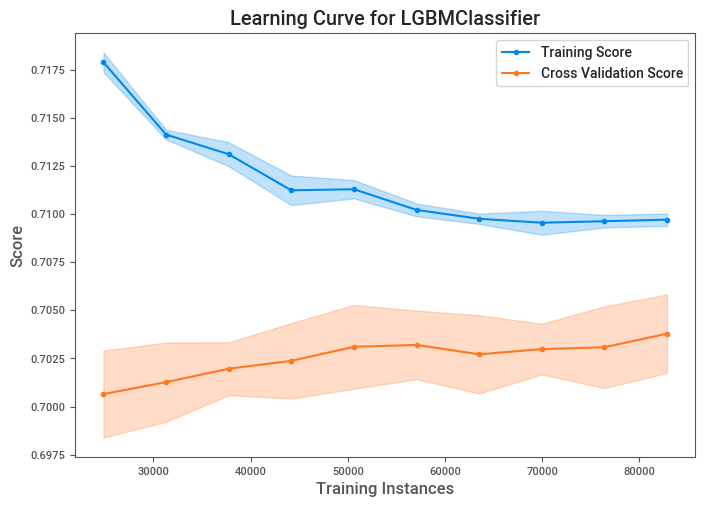

In [14]:
plot_model(best_model, plot = 'learning', use_train_data = True)

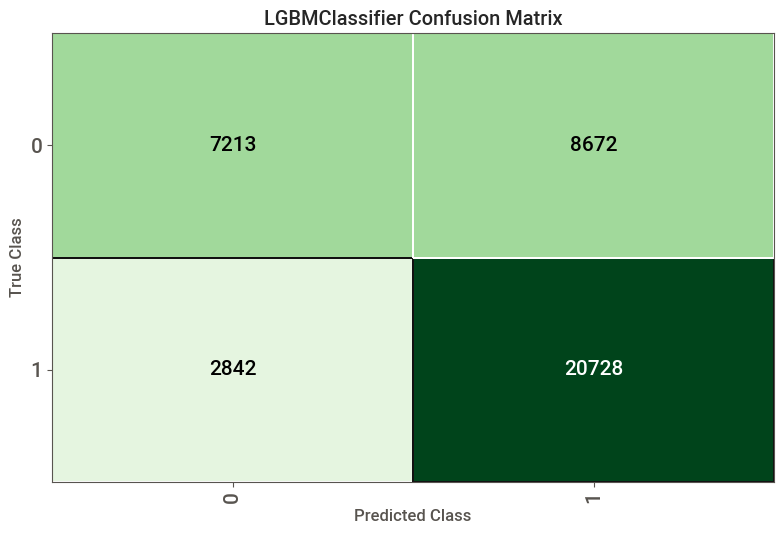

In [15]:
plot_model(best_model, 'confusion_matrix')

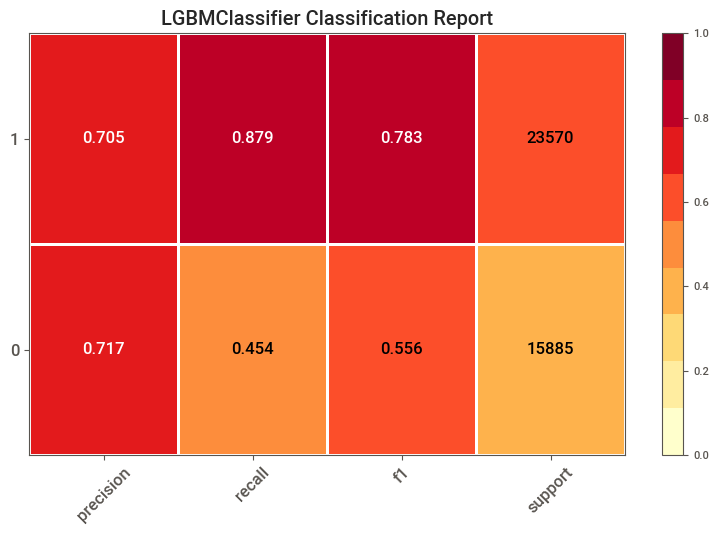

In [33]:
# evaluate_model(best_model)
plot_model(best_model, plot = 'class_report')

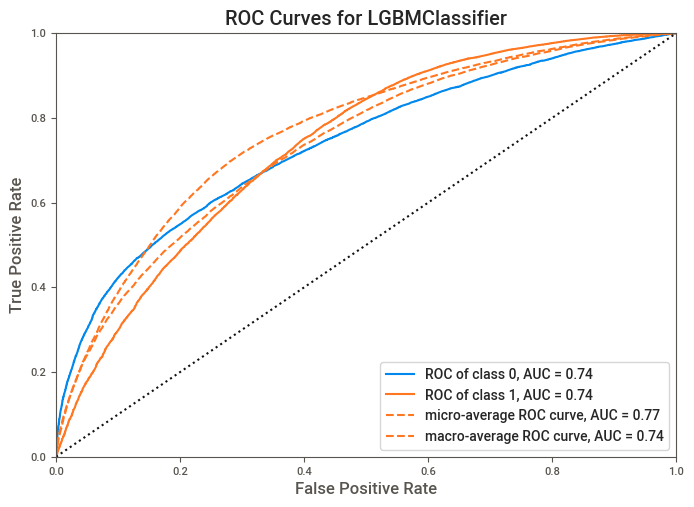

In [16]:
plot_model(best_model, plot="auc")

Interpretação abaixo. 
As variáveis que estão mais acima possuem maior importância para a previsão. 

- Altos níveis de Depressão (Sim, possui depressão) possuem impacto negativo com a variável resposta (Good Health) 
- Baixo níveis de Gender_Male (sexo feminino) possui impacto negativo com a variável resposta (Good Health) 
- Alto uso de álcool possui impacto negativo na variável resposta (Good Health)
- Altos níveis de dificuldade de concentração possuem impacto negativo com a variável resposta (Good Health)
- Altos níveis de Marital Married (casados) possuem impacto positivo sobre a variável resposta (Good Health) 
- Altos níveis de dificuldade de fazer afazeres sozinho possuem impacto negativo sobre a variável resposta (Good Health) 

https://pycaret.gitbook.io/docs/get-started/functions/analyze#interpret_model

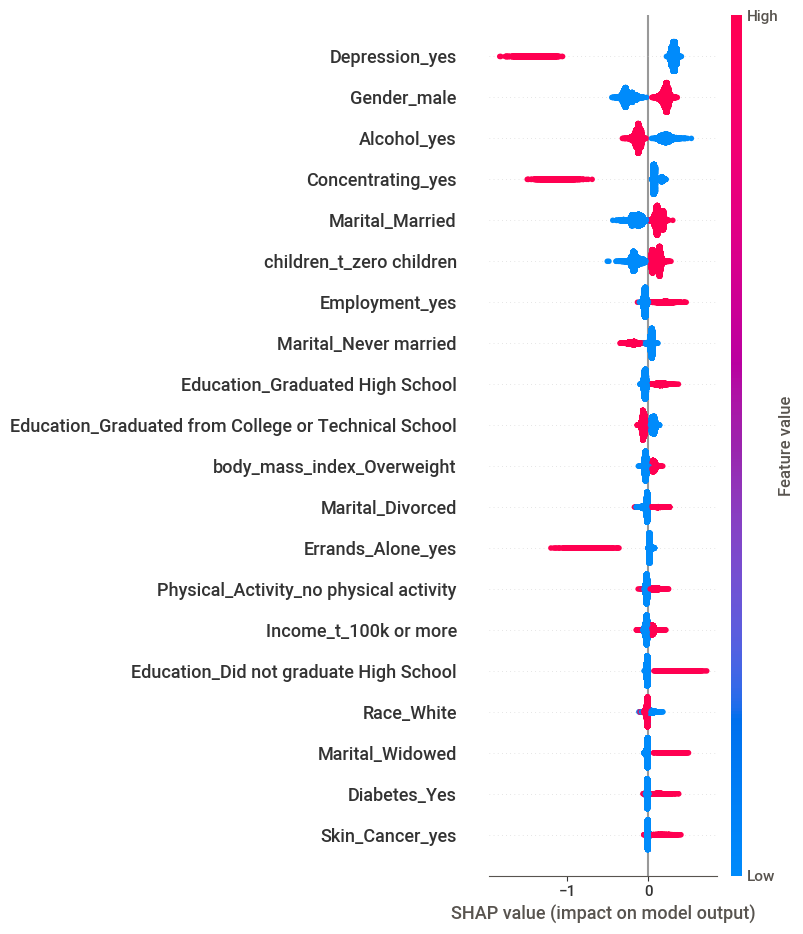

In [17]:
interpret_model(best_model, plot = 'summary')

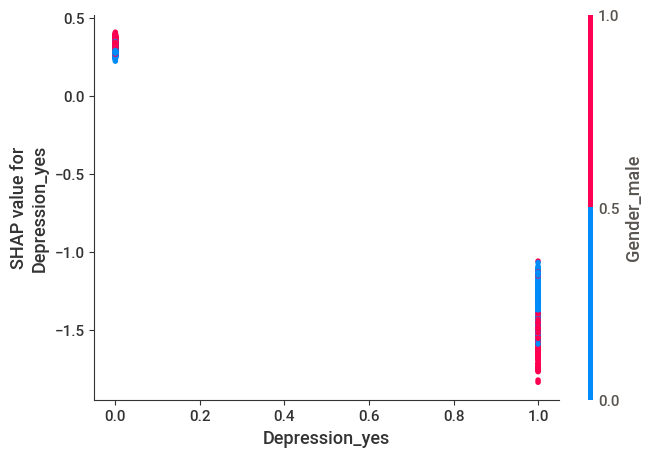

In [18]:
interpret_model(best_model, plot = 'correlation', feature = 'Depression_yes')

In [19]:
interpret_model(best_model, plot='reason', observation=1)

In [20]:
interpret_model(best_model, plot='reason', observation=3)

# Modelos com tunagem de hiperparâmetros

In [21]:
param_grid ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

tuned = tune_model(best_model, custom_grid=param_grid)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7023,0.7387,0.8733,0.7015,0.7780,0.3420,0.3614
1,0.7046,0.7364,0.8789,0.7019,0.7805,0.3461,0.3671
2,0.7052,0.7390,0.8762,0.7033,0.7803,0.3483,0.3683
3,0.6991,0.7372,0.8775,0.6972,0.7770,0.3327,0.3541
4,0.7015,0.7264,0.8747,0.7003,0.7778,0.3396,0.3597
5,0.7067,0.7378,0.8764,0.7047,0.7812,0.3521,0.3718
6,0.7046,0.7275,0.8747,0.7032,0.7796,0.3476,0.3671
7,0.7035,0.7373,0.8793,0.7006,0.7798,0.3431,0.3644
8,0.7062,0.7355,0.8791,0.7032,0.7814,0.3499,0.3707


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [22]:
final_model_baseline = finalize_model(tuned)

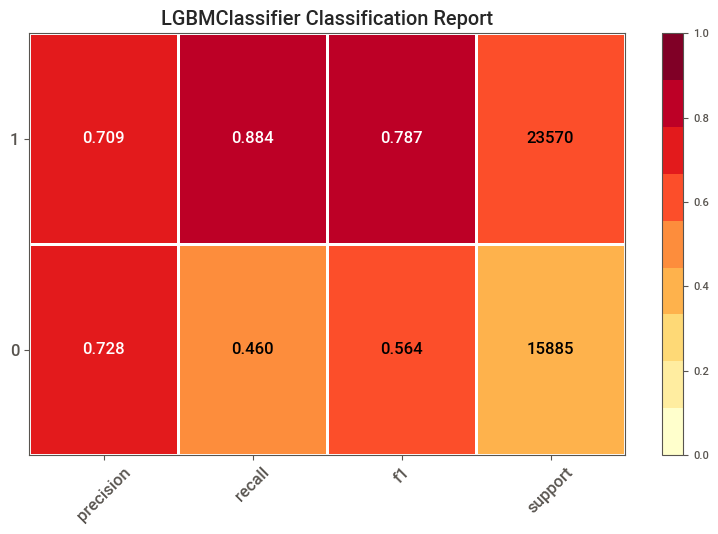

In [32]:
plot_model(final_model_baseline, plot = 'class_report')

In [23]:
unseen_predictions = predict_model(final_model_baseline, data=teste)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7072,0.7429,0.8828,0.6984,0.7799,0.3601,0.3828


In [24]:
unseen_predictions.head()

,Employment_yes,Gender_male,Physical_Activity_no physical activity,Race_Asian,Race_Black,Race_Hispanic,Race_Other race,Race_White,body_mass_index_Obese,body_mass_index_Overweight,...,COP_yes,Skin_Cancer_yes,Cancer_yes,children_t_zero children,Income_t_100k or more,Income_t_50k - 100k,Income_t_less than 50k,Mental_Health_Good,prediction_label,prediction_score
0,0,0,0,0,0,0,1,0,1,0,...,0,0,0,1,0,1,0,0,1,0.5665
1,0,1,1,0,0,0,0,1,0,1,...,0,1,0,1,0,0,1,1,1,0.8841
2,1,1,0,0,0,0,0,1,0,1,...,0,0,0,0,1,0,0,0,1,0.8016
3,0,1,0,0,0,0,0,1,1,0,...,0,0,0,0,1,0,0,0,1,0.7376
4,0,1,0,0,0,0,0,1,1,0,...,0,0,0,1,0,1,0,1,1,0.8135


In [25]:
cm = confusion_matrix(y_true=unseen_predictions['prediction_label'], y_pred=unseen_predictions['Mental_Health_Good'])
print(cm)

[[ 6200  2263]
 [ 7364 17052]]


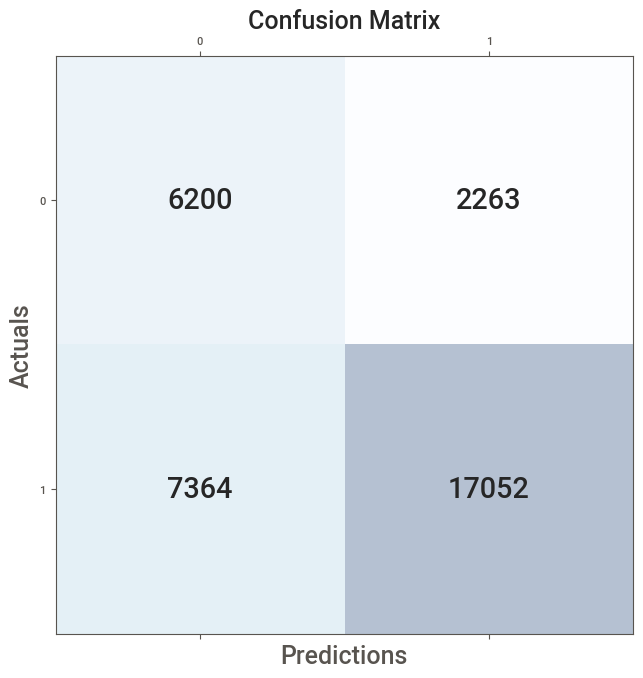

In [29]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [35]:
#pd.DataFrame.to_excel(unseen_predictions, "predictions_teste.xlsx")